# **Addestramento di una rete neurale Faster R-CNN per la detection di luoghi ad alto valore culturale**

## Librerie


Clonazione del repository *vision* di *pytorch* per utilizzare alcune funzioni di utilità per l'addestramento e valutazione del modello.

In [25]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0       # Check current version

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../
cp references/detection/coco_eval.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


Installazione della libreria albumentations con specifica versione 0.4.6.


Questa libreria verrà utilizzata per eseguire operazioni di trasformazione di *data augmentation* sui dati. 

In [26]:
! pip install albumentations==0.4.6

Codice da inserire nella funzione *check_bbox* del percorso /usr/local/lib/python3.7/dist-packages/albumentations/augmentations/bbox_utils.py per risolvere un problema di precisione in virgola mobile delle bounding box della libreria *albumentations*:

```
bbox=list(bbox)
for i in range(4):

  if (bbox[i]<0) :
    bbox[i]=0

  elif (bbox[i]>1) :
    bbox[i]=1

bbox=tuple(bbox)
```

Librerie da importare:

In [27]:
# Core libraries
import os
import sys
import re
import numpy as np
import random
import math
import time
import datetime
from datetime import date
import glob
import xml.etree.ElementTree as ET
import natsort
from matplotlib import pyplot as plt

# PyTorch
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import transforms as T                          # Module transform  (helper functions)
import utils                                    # Module utils      (helper functions)
from engine import train_one_epoch, evaluate    # Module engine     (helper functions)

# Data Augmentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Opencv
import cv2 as cv
from google.colab.patches import cv2_imshow

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Dataset

Sono stati individuati **24 punti di interesse** suddivisi in altrettante directories. 



Ogni punto di interesse contiene, a sua volta, altre tre directory:
- *imgs*: contiene le immagini di dimensione 900 x 1300;
- *annotations*: contiene le annotazioni (coordinate delle bounding box) di ogni immagine catturata;
- *bounding_box*: contiene le immagini con le bouding box individuate.


Il dataset è consultabile al seguente [link](https://drive.google.com/drive/folders/1MenVMP6C9Vuo7JJ-iesAd1KfsemAvSLy?usp=sharing)

### Connessione a Google Drive

Connessione a google drive per scaricare il dataset.

In [28]:
from google.colab import drive
drive.mount('/content/gdrive/')

path = "gdrive/MyDrive/DataSet/DatasetMonuments/"   # Replace with your path

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Caricamento del dataset

La funzione *split_directory* permette di formattare il testo dato in input sulla base delle lettere maiuscole.

In [29]:
def split_directory(title):
    r"""
    Split text of the directory.

    :param title: text to split.
    
    :return: text with the tabulations.
    """
    
    title = title[0].upper() + title[1:]
    folder = re.findall('[A-Z][^A-Z]*', title)
    result = ""

    for i, item in enumerate(folder):
        result += str(item) + (" " if (i + 1) != len(folder) else "")

    return result

La funzione *get_transform* applica trasformazioni di *data augmentation* prima di darli in input alla rete.

In [30]:
def get_train_transform():
  """
  Apply the transformations to the training set.
  """
  return A.Compose([A.Flip(0.5), ToTensorV2(p=1.0)],
                    bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
  """
  Apply the transformations to the validation set.
  """
  return A.Compose([ToTensorV2(p=1.0)],
                    bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
  """
  Apply the transformations to the test set.
  """
  return A.Compose([ToTensorV2(p=1.0)])

Per ogni etichetta di training e validation set, verrà creata un'istanza della classe *DatasetCulturalHeritage*

In [31]:
class DatasetCulturalHeritage(Dataset):
  """
  Class to load the dataset of a specific label of the training or validation set.
  """

  def __init__(self, label, label_ds, transforms=None, path="gdrive/MyDrive/DataSet/DatasetMonuments/", height=512, width=512):
      """
      Load the dataset.

      :param label: label of the dataset.
      :param label_ds: label of the dataset not formatted. 
      :param dir: directory of the monumnet/place.
      :param transform: transform to apply to the data.
      """

      self.label        = label
      self.label_ds     = label_ds
      self.path         = path

      self.imgs_list        = glob.glob(path + self.label_ds + '/imgs/*.JPG') + glob.glob(path + self.label_ds + '/imgs/*.jpg')
      self.annotations_list = glob.glob(path + self.label_ds + '/annotations/*.xml')
      self.imgs_list.sort()
      self.annotations_list.sort()
      
      self.transforms = transforms
      self.height = height
      self.width = width
    
  def __getitem__(self, index):
      """
      Get the image and its bouding boxes.

      :param index: index of the specific image.
      """
      global total_labels

      img_path, annotations_path = self.imgs_list[index], self.annotations_list[index]
      img = cv.imread(img_path)
      height, width, _ = img.shape

      img = cv.resize(img, (self.width, self.height), cv.INTER_AREA)
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float32)
      img /= 255.0

      # Bouding boxes
      bounding_boxes = []
      labels = []
      _boxes, _labels = get_bounding_boxes(annotations_path)

      for box, label in zip(_boxes, _labels):

        num_label = total_labels.index(label)
        labels.append(num_label)

        # TODO check to fix label returned from the net
        #print(f"For label: {self.label_ds}, index: {num_label}")
      
        # Extracting scaled coordinates for the size of the current image
        x_min = (box[0][0] / width) * self.width
        x_max = (box[1][0] / width) * self.width
        y_min = (box[0][1] / height)* self.height
        y_max = (box[1][1] / height)* self.height

        bounding_boxes.append([x_min, y_min, x_max, y_max])

      if len(bounding_boxes) == 0:
        # Image without bounding box
        labels.append(0)                                              # Label 0 for free class
        boxes = torch.as_tensor([[0, 1, 2, 3]], dtype=torch.float32)  # Fake bounding box
        
      else:
        # Image with bounding box
        boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)

      # Labels
      labels = torch.as_tensor(labels, dtype=torch.int64)

      # Area
      area =  (boxes[:, 3] - boxes[:, 1]) * \
              (boxes[:, 2] - boxes[:, 0])

      # Id
      img_id = torch.tensor([index])

      is_crowd = torch.zeros((len(boxes),), dtype=torch.int64)

      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["image_id"] = img_id
      target["area"] = area
      target["iscrowd"] = is_crowd

      if self.transforms is not None:

        result_transform = self.transforms(image = img,
                                           bboxes = target['boxes'],
                                           labels = labels)
        
        img = result_transform['image']
        target['boxes'] = torch.Tensor(result_transform['bboxes'])

      return img, target

  def length(self):
      return len(self.imgs_list), len(self.annotations_list)

  def __len__(self):
      assert len(self.imgs_list) == len(self.annotations_list)
      return len(self.imgs_list)

Per ogni etichetta del test set, verrà creata un'istanza della classe *DatasetCulturalHeritageTest*

In [32]:
class DatasetCulturalHeritageTest(Dataset):
  """
  Class to load the dataset of a specific label of the test set.
  """

  def __init__(self, label, label_ds, transforms=None, path="gdrive/MyDrive/DataSet/DatasetMonuments/", height=512, width=512):
      """
      Load the dataset.

      :param label: label of the dataset.
      :param label_ds: label of the dataset not formatted. 
      :param dir: directory of the monumnet/place.
      :param transform: transform to apply to the data.
      """

      self.label        = label
      self.label_ds     = label_ds
      self.path         = path

      self.imgs_list        = glob.glob(path + self.label_ds + '/imgs/*.JPG') + glob.glob(path + self.label_ds + '/imgs/*.jpg')
      self.annotations_list = glob.glob(path + self.label_ds + '/annotations/*.xml')
      self.imgs_list.sort()
      self.annotations_list.sort()
      
      self.transforms = transforms
      self.height = height
      self.width = width
    
  def __getitem__(self, index):
      """
      Get the image.

      :param index: index of the specific image.
      """

      img_path, annotations_path = self.imgs_list[index], self.annotations_list[index]
      img = cv.imread(img_path)
      height, width, _ = img.shape

      img = cv.resize(img, (self.width, self.height), cv.INTER_AREA)
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float32)
      img /= 255.0

      if self.transforms is not None:

        result_transform = self.transforms(image = img)
        img = result_transform['image']
        
      return img

  def length(self):
      return len(self.imgs_list)

  def __len__(self):
      return len(self.imgs_list)

Caricamento del dataset.

In [33]:
global total_labels

path = "gdrive/MyDrive/DataSet/DatasetMonuments/"  
imgs_list = []

num_imgs = 0
num_annotations = 0
total_labels = []

print("Caricamento dataset in corso ...\n\n")

dirs = natsort.natsorted(os.listdir(path))
dataset_train = []
dataset_valid = []
dataset_test = []

for index, dir in enumerate(dirs):

  name_class = split_directory(dir)
  train = DatasetCulturalHeritage(label=name_class, label_ds=dir, path=path, transforms=get_train_transform())
  valid = DatasetCulturalHeritage(label=name_class, label_ds=dir, path=path, transforms=get_valid_transform())
  test  = DatasetCulturalHeritageTest(label=name_class, label_ds=dir, path=path, transforms=get_test_transform())

  imgs, annotations = train.length()
  num_imgs += imgs
  num_annotations += annotations

  if name_class == "Free":
    # The free class must be at the top of the list
    total_labels.insert(0, name_class)
  else:
    total_labels.append(name_class)

  dataset_train.append(train)
  dataset_valid.append(valid)
  dataset_test.append(test)

  print(f"Classe [{name_class}] caricata!\n")

print("Caricamento terminato.")

Caricamento dataset in corso ...


Classe [Arco Di Trionfo] caricata!

Classe [Berlina Mosca] caricata!

Classe [Casa Rossini] caricata!

Classe [Cattedrale Santa Maria Assunta] caricata!

Classe [Centro Arti Visive Pescheria] caricata!

Classe [Chiesa San Agostino] caricata!

Classe [Fontana Piazza] caricata!

Classe [Free] caricata!

Classe [Gioachino Rossini] caricata!

Classe [Giuseppe Garibaldi] caricata!

Classe [Palazzo Baviera] caricata!

Classe [Palazzo Comunale] caricata!

Classe [Palazzo Delle Poste] caricata!

Classe [Palazzo Ducale] caricata!

Classe [Palazzo Olivieri] caricata!

Classe [Palla Di Pomodoro] caricata!

Classe [Parrocchia Santa Maria] caricata!

Classe [Portale San Domenico] caricata!

Classe [Rocca Costanza] caricata!

Classe [Scultura Della Memoria] caricata!

Classe [Statua Giulio Perticari] caricata!

Classe [Teatro Rossini] caricata!

Classe [Teatro Sperimentale] caricata!

Classe [Villa Caprile] caricata!

Classe [Villino Ruggeri] caricata!

Caricamento

In [34]:
print(f"Numero totale di immagini: {num_imgs}\n")
print(f"Numero totale di annotazioni: {num_annotations}", end="\n\n")
print(f"Numero totale di classi: {len(total_labels)}")

Numero totale di immagini: 953

Numero totale di annotazioni: 953

Numero totale di classi: 25


### Visualizzazione del dataset

La funzione *get_bounding_boxes* permette di ottenere le coordinate di tutte le bouding boxes di uno specifico file .xml dato in input.

La funzione *format_labels* permette semplicemente di far 'matchare' le labels ottenute dal nome delle loro directories con quelle memorizzate nel file .xml (annotazione) di una specifica immagine.

In [35]:
def get_bounding_boxes(path_annotation):
  r"""
  Get all bounding boxes of a specific file xml.
  
  :param path_annotation: file from which to get bounding boxes.
  """

  bounding_box_list = []
  labels = []
  tree = ET.parse(path_annotation)
  root = tree.getroot()

  # Get all bounding boxes
  j = 6
  while True:
      try:
          object = root[j]

          labels.append(object[0].text)

          box = object[4]
          x_min, y_min, x_max, y_max = int(box[0].text) - 1, int(box[1].text) - 1, int(box[2].text) - 1, int(box[3].text) - 1
          bounding_box_list.append([[x_min, y_min], [x_max, y_max]])

          j += 1
          
      except Exception as e:
          break

  return bounding_box_list, format_labels(labels)

def format_labels(list_labels):
  r"""
  Match the labels.

  :param list_label: list containing the labels to math.
  """

  new_list = []
  for label in list_labels:

    if label == "Scultura della Memoria":
      new_list.append("Scultura Della Memoria")
      
    elif label == "Palla di Pomodoro":
      new_list.append("Palla Di Pomodoro")

    elif label == "Arco di Trionfo":
      new_list.append("Arco Di Trionfo")

    elif label == "Palazzo delle Poste":
      new_list.append("Palazzo Delle Poste")

    elif label == "Fontana Piazza del Popolo":
      new_list.append("Fontana Piazza")

    elif label == "Giulio Perticari":
      new_list.append("Statua Giulio Perticari")
      
    else:
      new_list.append(label)
  
  return new_list

La funzione *stack_images* permette di mostrare una lista orizzontale e verticale di immagini.

In [36]:
def stack_images(scale, img_array):
    r"""
    Stack the images based on the number of them by rows and columns.

    :param scale: scale factor.
    :param img_array: array of images.

    :return: array of images to show.
    """

    rows = len(img_array)
    cols = len(img_array[0])

    rowsAvailable = isinstance(img_array[0], list)

    width = img_array[0][0].shape[1]
    height = img_array[0][0].shape[0]

    if rowsAvailable:
        for x in range(0, rows):
            for y in range(0, cols):

                if img_array[x][y].shape[:2] == img_array[0][0].shape[:2]:
                    img_array[x][y] = cv.resize(img_array[x][y], (0, 0), None, scale, scale)
                else:
                    img_array[x][y] = cv.resize(img_array[x][y], (img_array[0][0].shape[1], img_array[0][0].shape[0]),
                                                None, scale, scale)

                if len(img_array[x][y].shape) == 2:
                    img_array[x][y] = cv.cvtColor(img_array[x][y], cv.COLOR_GRAY2BGR)

        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows

        for x in range(0, rows):
            hor[x] = np.hstack(img_array[x])
        ver = np.vstack(hor)

    else:
        for x in range(0, rows):

            if img_array[x].shape[:2] == img_array[0].shape[:2]:
                img_array[x] = cv.resize(img_array[x], (0, 0), None, scale, scale)
            else:
                img_array[x] = cv.resize(img_array[x], (img_array[0].shape[1], img_array[0].shape[0]), None, scale,
                                         scale)

            if len(img_array[x].shape) == 2:
                img_array[x] = cv.cvtColor(img_array[x], cv.COLOR_GRAY2BGR)

        hor = np.hstack(img_array)
        ver = hor

    return ver


La funzione *draw_description* disegna il nome della classe in basso nell'immagine.

In [37]:
def draw_description(img, text):
    r"""
    Draw description image.

    :param text: image description.
    :param img: image in which to insert the descrition.
    
    :return: image with description.
    """

    bottom = int(0.04 * img.shape[0])
    img = cv.copyMakeBorder(img, 0, bottom, 0, 0, cv.BORDER_CONSTANT, None, (255, 255, 255))

    height, _, _ = img.shape
    cv.putText(img, text, (0, height - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    return img

La funzione *convert_point_to_tuple* converte una coordinata (punto x,y) in una tupla.

In [38]:
def convert_point_to_tuple(point):
    x, y = point
    return (x,y)

Il codice seguente mostra una griglia di 4 immagini casuali prese dal dataset. Per ogni immagine, a sinistra, viene mostrata quella originale e a destra la stessa immagine con le bounding box individuate.

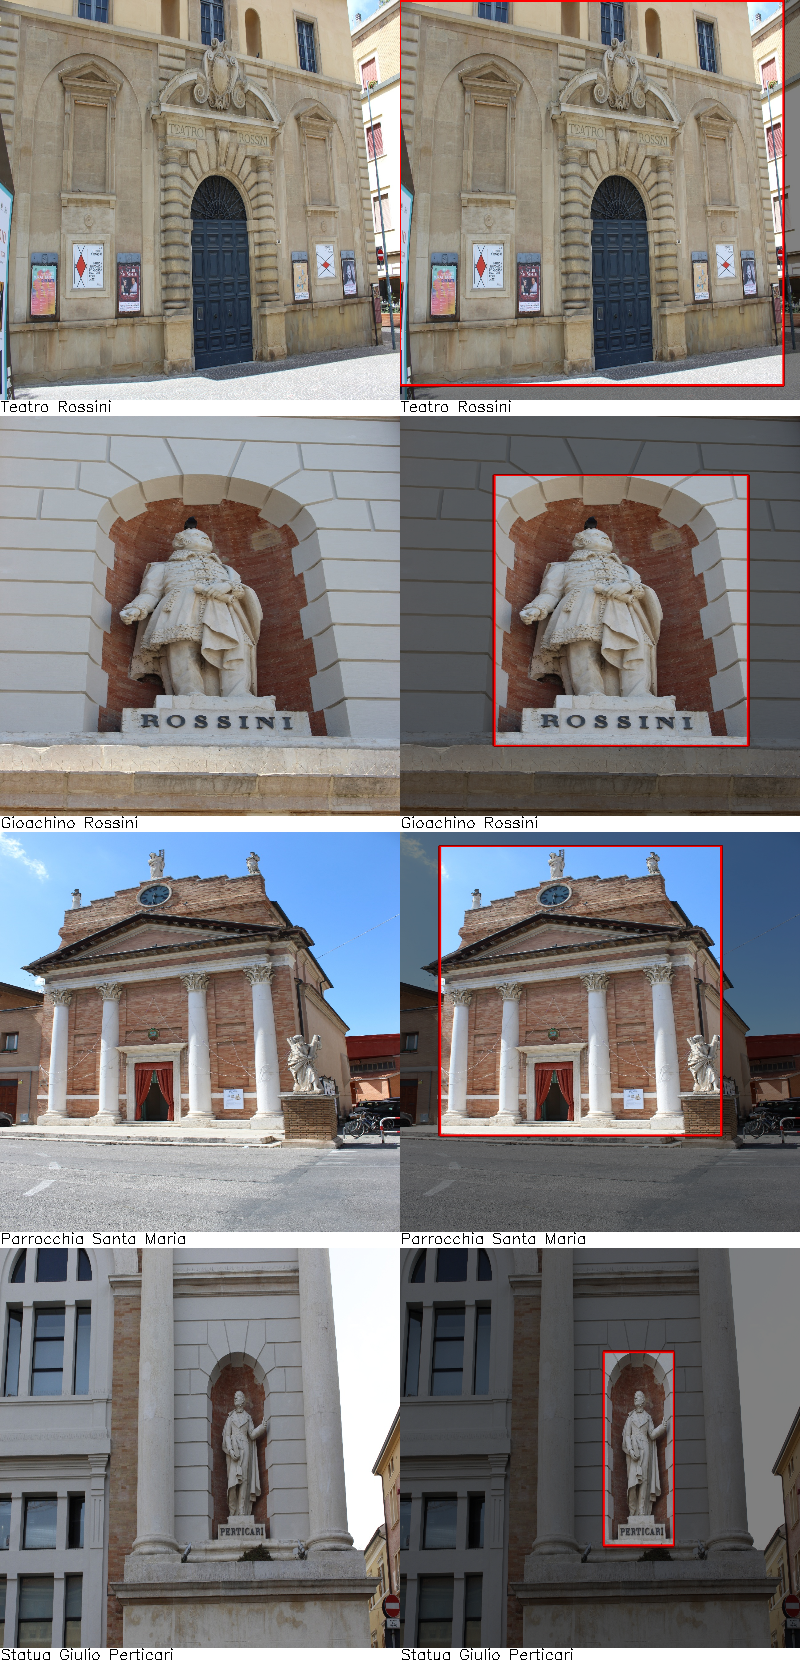

In [39]:
labels_to_show = []       # Labels of the images to show
bounding_box_list = []    # List of the boudning boxes drawed.
imgs_read_list = []       # List of the images read (no trasformations)
imgs_bb = []              # List of the images trasformated (with bouding boxes)
title_images_list = []    # Label formattated.

labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))
labels_to_show.append(random.randint(0, len(dirs) - 1))

alpha = 0.5

for i in range(4):
    bounding_box_list.clear()

    index_label = labels_to_show[i]
    imgs = dataset_train[index_label]

    index_img = random.randint(0, len(imgs) - 1)

    # Label
    label = imgs.label_ds

    # Parse xml
    path_annotation = imgs.annotations_list[index_img]

    # Get bounding boxes
    bounding_box_list, _ = get_bounding_boxes(path_annotation)

    # Image
    path_img = imgs.imgs_list[index_img]

    img_read = cv.imread(path_img)

    img_original = cv.resize(img_read, (400,400))
    imgs_read_list.append(img_original)

    # Mask
    mask = np.zeros_like(img_read[:, :, 0])

    for j, box in enumerate(bounding_box_list):
        # Draw rectangle
        cv.rectangle(img_read, convert_point_to_tuple(box[0]), convert_point_to_tuple(box[1]), (0, 0, 255), 5)

        polygon = np.array([[bounding_box_list[j][0]], [[bounding_box_list[j][1][0],
                            bounding_box_list[j][0][1]]], [bounding_box_list[j][1]],
                            [[bounding_box_list[j][0][0], bounding_box_list[j][1][1]]]])
        
        cv.fillConvexPoly(mask, polygon, 1)

    # Get polygon
    img = cv.bitwise_and(img_read, img_read, mask=mask)
    img = cv.addWeighted(img_read.copy(), alpha, img, 1 - alpha, 0)
    img = cv.resize(img, (400, 400))

    imgs_bb.append(img)
    title_images_list.append(split_directory(label))

imgs_stack = stack_images(1, ([draw_description(imgs_read_list[0], title_images_list[0]), draw_description(imgs_bb[0], title_images_list[0])],
                              [draw_description(imgs_read_list[1], title_images_list[1]), draw_description(imgs_bb[1], title_images_list[1])],
                              [draw_description(imgs_read_list[2], title_images_list[2]), draw_description(imgs_bb[2], title_images_list[2])],
                              [draw_description(imgs_read_list[3], title_images_list[3]), draw_description(imgs_bb[3], title_images_list[3])]))

cv2_imshow(imgs_stack)

### Trainining, validation e test set

La funzione *split_dataset* suddivide il dataset in training, validation e test set rispettivamente al 70% (training), 20% (validation) e 10% (test).

In [40]:
def split_dataset(dataset_train, dataset_valid, dataset_test):
    r"""
    Split dataset in training, validation and test set:
        - 70% training set;
        - 20% validation set:
        - 10% test set.

    :param dataset: dataset to split.
    
    :return : training, validation and test set.
    """

    length_dataset = len(dataset_train)

    length_train = np.int_(length_dataset * 0.7)
    length_validate = np.int_(length_dataset * 0.2)

    training_dataset    = Subset(dataset_train, range(0, length_train))
    validation_dataset  = Subset(dataset_valid, range(length_train, length_train + length_validate))  
    test_dataset        = Subset(dataset_test, range(length_train + length_validate, len(dataset_train)))

    return training_dataset, validation_dataset, test_dataset

Suddivisione del dataset in training, validation e test set.

In [41]:
training_set = []
validation_set = []
test_set = []

num_imgs = 0
num_training = 0
num_validation = 0
num_test = 0

for train, valid, test in zip(dataset_train, dataset_valid, dataset_test):

  training_dataset, validation_dataset, test_dataset = split_dataset(train, valid, test)

  num_imgs += len(training_dataset) + len(validation_dataset) + len(test_dataset)
  num_training += len(training_dataset)
  num_validation += len(validation_dataset)
  num_test +=  len(test_dataset)

  training_set.append(training_dataset)
  validation_set.append(validation_dataset)
  test_set.append(test_dataset)

training_dataset, validation_dataset, test_dataset = ConcatDataset(training_set), ConcatDataset(validation_set), ConcatDataset(test_set)

print(f"** Dataset caricato correttamente! Totale immagini: {num_imgs} **\n")
print(f"Dimensione training: {num_training} immagini - (70%)")
print(f"Dimensione validation: {num_validation} immagini - (20%)")
print(f"Dimensione test: {num_test} immagini - (10%)\n\n")
print(f"Totale immagini suddivise: {len(training_dataset) + len(validation_dataset) + len(test_dataset)}\n\n")

** Dataset caricato correttamente! Totale immagini: 953 **

Dimensione training: 657 immagini - (70%)
Dimensione validation: 181 immagini - (20%)
Dimensione test: 115 immagini - (10%)


Totale immagini suddivise: 953




Creazione del *Data Loader* rispettivamente per training, validation e test set.

In [42]:
batch_size = 8

# Training set
training_loader = DataLoader(training_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=4,
                             collate_fn=utils.collate_fn)

# Validation set
validation_loader = DataLoader(validation_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=4,
                               collate_fn=utils.collate_fn)

# Test set
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         drop_last=False,
                         num_workers=4,
                         collate_fn=utils.collate_fn)

## Modello della rete

La funzione *get_model* inizializza la rete neurale Faster R-CNN preaddestrata.

In [43]:
def get_model(num_classes):
  r"""
  Model initialization.
  
  :param num_classes: number of classes of the problem.
  """

  # Load the model pretrained
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  # Get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

Definizione del modello.

In [44]:
# Classes
num_classes = len(total_labels) + 1  # N classes + background

# Model
model = get_model(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nRuntime used: {device}\n\n")
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

# Optimizer
optimizer = torch.optim.SGD(params,
                            lr=0.03,
                            momentum=0.9)
                            #weight_decay=0.0005)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
lr_scheduler = None

# Epoch
num_epochs = 20

print("** SUMMARY TRAINING **\n")
print(f"- Classes of the problem: {num_classes};")
print(f"- Epochs number: {num_epochs};")
print(f"- Batch size: {batch_size};")
print(F"- Optimizer: {optimizer.__class__.__name__},")
print(f"             Learning Rate: {optimizer.defaults['lr']},")
print(f"             Momentum: {optimizer.defaults['momentum']}.")


Runtime used: cuda


** SUMMARY TRAINING **

- Classes of the problem: 26;
- Epochs number: 20;
- Batch size: 8;
- Optimizer: SGD,
             Learning Rate: 0.03,
             Momentum: 0.9.


## Addestramento

La funzione *save_model* permette di salvare il modello addestrato. 

La funzione *load_model* permette di caricare il modello precedentemente addestrato.

In [45]:
def save_model(model, optimizer, num_epochs, path):
  """
  Save model.
  
  :param model: model net.
  :param optimizer: optimizer.
  :param num_epochs: epoch numbers.
  :param path: path to save model.
  """

  torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
  
def load_model(optimizer, path, num_classes, device):
  """
  Load model.
  
  :param optimizer: optimizer.
  :param num_epochs: epoch numbers.
  :param path: path to load model.
  :param device: type of the runtime.
  """

  model = get_model(num_classes).to(device)

  if torch.cuda.is_available():
    file = torch.load(path)
  else:
    file = torch.load(path, map_location='cpu')

  model.state_dict(file['model_state_dict'])
  optimizer.load_state_dict(file['optimizer_state_dict'])
  epochs = file['epoch']

  return model, optimizer, epochs, lr_scheduler

In [46]:
# Load model
#model, optimizer, num_epochs, lr_scheduler = load_model(optimizer, "gdrive/MyDrive/DataSet/Model/CulturalHeritage/03092021_2/net_03092021_10.pth", num_classes, device)

La funzione *train_one_epoch* esegue l'addestramento della rete per ogni epoca sul training set.

In [47]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
  """
  Traininf for each epoch.

  :param model: model net.
  :param optimizer: optimize used.
  :param data_loader: training data.
  :param device: type of runtime used.
  :param epoch: current epoch of training.
  :param print_freq: training parameter printing frequency.

  :return metric_logger: logger of the training.
  """

  model.train()
  metric_logger = utils.MetricLogger(delimiter="  ")
  metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
  header = 'Epoch: [{}]'.format(epoch + 1)

  lr_scheduler = None
  if epoch == 0:
      warmup_factor = 1. / 1000
      warmup_iters = min(1000, len(data_loader) - 1)

      lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

  for images, targets in metric_logger.log_every(data_loader, print_freq, header):
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())

      # Reduce losses over all GPUs for logging purposes
      loss_dict_reduced = utils.reduce_dict(loss_dict)
      losses_reduced = sum(loss for loss in loss_dict_reduced.values())

      loss_value = losses_reduced.item()

      if not math.isfinite(loss_value):
          print("Loss is {}, stopping training".format(loss_value))
          print(loss_dict_reduced)
          sys.exit(1)

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      if lr_scheduler is not None:
          lr_scheduler.step()

      metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
      metric_logger.update(lr=optimizer.param_groups[0]["lr"])

  return metric_logger

La funzione *training_loop* esegue l'addestramento del modello.

In [48]:
training = True

def training_loop(model, training_loader, validation_loader, num_epochs, optimizer, lr_scheduler):
  """
  Training loop.

  :param model: model net.
  :param training_loader: training data.
  :param validation_loader: validation data.
  :param num_epochs: number of epochs.
  :param optimizer: optimize used.
  :param lr_scheduler: scheduler used.

  :return training_loss: loss of the training.
  """

  training_loss_list = []
  train_loss_min = 0.9

  classifier_loss_list = []
  box_region_loss_list = []

  today = date.today()
  current_date = today.strftime("%d%m/%Y").replace("/", "")

  try:
    os.mkdir(f"gdrive/MyDrive/DataSet/Model/CulturalHeritage/{current_date}")
  except:
    pass

  for epoch in range(num_epochs):
      path_model = f"gdrive/MyDrive/DataSet/Model/CulturalHeritage/{current_date}/net_{current_date}_{epoch + 1 }.pth"
      
      # From https://github.com/pytorch/vision/blob/master/references/detection/engine.py
      logger = train_one_epoch(model, optimizer, training_loader, device, epoch, print_freq=40)

      metric_logger = logger.meters
      loss = metric_logger['loss']
      classifier_loss = metric_logger['loss_classifier']
      box_reg_loss = metric_logger['loss_box_reg']

      training_loss_list.append(np.mean(loss.deque))
      classifier_loss_list.append(np.mean(classifier_loss.deque))
      box_region_loss_list.append(np.mean(box_reg_loss.deque))

      # Save best model
      if training_loss_list[epoch] <= train_loss_min:
            print('Training loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.
                  format(train_loss_min, training_loss_list[epoch]))
            
            save_model(model, optimizer, epoch, path_model)
            train_loss_min = training_loss_list[epoch]
      
      # Update the learning rate
      if lr_scheduler is not None:
        lr_scheduler.step()

      # Evaluate on the validation set
      metrics = evaluate(model, validation_loader, device=device)

      # Save model every 5 epochs
      if (epoch + 1) % 5 == 0:
        save_model(model, optimizer, epoch, path_model)

  return training_loss_list, classifier_loss_list, box_region_loss_list

if training:
  training_loss, classifier_loss, box_reg_loss = training_loop(model,
                                                               training_loader,
                                                               validation_loader,
                                                               num_epochs,
                                                               optimizer,
                                                               lr_scheduler)

Epoch: [1]  [ 0/83]  eta: 0:06:53  lr: 0.000395  loss: 3.6126 (3.6126)  loss_classifier: 3.4733 (3.4733)  loss_box_reg: 0.0775 (0.0775)  loss_objectness: 0.0530 (0.0530)  loss_rpn_box_reg: 0.0088 (0.0088)  time: 4.9821  data: 1.3860  max mem: 7339
Epoch: [1]  [40/83]  eta: 0:02:31  lr: 0.015015  loss: 0.2230 (0.7343)  loss_classifier: 0.0036 (0.4843)  loss_box_reg: 0.0000 (0.0592)  loss_objectness: 0.0525 (0.1241)  loss_rpn_box_reg: 0.1150 (0.0667)  time: 3.4558  data: 0.0407  max mem: 7607
Epoch: [1]  [80/83]  eta: 0:00:10  lr: 0.029635  loss: 0.2706 (0.5163)  loss_classifier: 0.1438 (0.3234)  loss_box_reg: 0.0981 (0.0802)  loss_objectness: 0.0145 (0.0752)  loss_rpn_box_reg: 0.0052 (0.0376)  time: 3.5031  data: 0.0395  max mem: 7607
Epoch: [1]  [82/83]  eta: 0:00:03  lr: 0.030000  loss: 0.2706 (0.5138)  loss_classifier: 0.1441 (0.3216)  loss_box_reg: 0.0981 (0.0818)  loss_objectness: 0.0143 (0.0736)  loss_rpn_box_reg: 0.0059 (0.0368)  time: 3.3574  data: 0.0374  max mem: 7607
Epoch: [

KeyboardInterrupt: ignored

## Risultati ottenuti

La funzione *plot_history* mostra i grafici sui risultati ottenuti. 

In [ ]:
def plot_history(train_loss, classifier_loss, box_reg_loss, num_epochs):
    r"""
    Shows the results obtained.

    :param train_loss: loss obtained from the training data.
    :param num_epochs: number of epochs.
    """

    plt.plot(range(1, num_epochs + 1), train_loss, color='r', label='Training Loss')
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.title('Loss history')
    plt.show()

    plt.plot(range(1, num_epochs + 1), classifier_loss, color='g', label='Classifier Loss')
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.title('Classifier loss history')
    plt.show()

    plt.plot(range(1, num_epochs + 1), box_reg_loss, color='b', label='Box Region Loss')
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.title('Box region loss history')
    plt.show()

plot_history(training_loss, classifier_loss, box_reg_loss, num_epochs)

La funzione *test_dataset* valuta i risultati ottenuti dalla rete su tutte le immagini del test set.

In [ ]:
def test_dataset(model):
  """
  Evaluate the results of the net.

  :param model: model net.
  """

  results = []
  test_images = []

  for images, _ in test_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):
        test_images.append(image)   

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        label = outputs[i]['labels'].data.cpu().numpy()

        predictions = boxes
        preds_sorted_idx = np.argsort(scores)[::-1]
        preds_sorted = predictions[preds_sorted_idx]
        boxes = predictions
        
        output = {
            'boxes': boxes,
            'scores': scores,
            'labels': label,
        }

        # Saving outputs and scores
        results.append(output) 

  return test_images, results

La funzione *plot_test_results* mostra i risultati della rete sul test set. 

Vengono mostrate sei immagini casuali del test set.

Per ogni immagine, se la rete identifica un 'oggetto', viene disegnata una bounding box e l'etichetta ad essa associata.

In [ ]:
def plot_test_results(images, results, columns=2, rows=3, detection_threshold = 0.5):
  """
  Shows the results obtained from the net.

  :param images: images of the test set.
  :param results: results obtained by the net.
  :param columns: number of the columns.
  :param rows: number of the rows.
  :param detection_threshold: maximum threshold to discard the results.
  """

  fig, axs = plt.subplots(columns, rows, figsize=(32, 16))
  axs = axs.ravel()

  # Tmp lists
  images_copy = images.copy()
  results_copy = results.copy()

  for i in range(6):

      index = random.randint(0, len(images_copy) - 1)
      img = images_copy[index]
      result = results_copy[index]

      del images_copy[index]
      del results_copy[index]

      sample = img.permute(1,2,0).cpu().numpy()

      boxes   = result['boxes']
      scores  = result['scores']
      labels  = result['labels']

      obj_lists =  list(zip(boxes, labels))

      boxes_list = []
      for index, items in enumerate(obj_lists):
        box = items[0]    
        box = box[scores[index] > detection_threshold].astype(np.int32)
        if len(box) > 0:
          boxes_list.append([box, items[1]]) # Tuple (boxes, labels)


      for (box, label) in boxes_list:
        x, y, w, h = box[0]
        cv.rectangle(sample, (x, y), (w, h), (255, 0, 0), 2)
        text_label = total_labels[label]
        cv.putText(sample, text_label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)

        print(f"Index label: {label}, Text label: {text_label}", end="\n\n")
      
      axs[i].set_axis_off()
      axs[i].imshow(sample)

Caricamento del modello addestrato e valutazione sul test set.

In [ ]:
today = date.today()
current_date = today.strftime("%d%m/%Y").replace("/", "")

path = f"gdrive/MyDrive/DataSet/Model/CulturalHeritage/{current_date}/net_{current_date}_{num_epochs}.pth"
#model, _, _, _ = load_model(optimizer, path, num_classes, device)
model.eval()
test_images, outputs = test_dataset(model)

Visualizzazione dei risultati.

In [ ]:
plot_test_results(test_images, outputs)

Errori:

- Verificare la giusta corrispondenza delle label tra quando vengono allenate dalla rete e quando vengono valutati i risultati. (TODO nella classe CulturalHeritage)

Da fare:

- Aggiornare la documentazione a progetto finito.